In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

In [2]:
def extract_score(file_name, seed_list, test_flag, ver2_flag=1):
    total_score, total_len = None, 0
    total_sample = None
    for seed in seed_list:
        if test_flag == 0:
            df = pd.read_csv(file_name + str(seed) + '/train.csv')
        else:
            df = pd.read_csv(file_name + str(seed) + '/eval.csv')
        if total_score is None:
            if ver2_flag == 1:
                total_score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                total_score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                total_score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                total_score = df['episode_reward'].values
            elif ver2_flag == 5:
                total_score = df['true_episode_success'].values * 100
            else:
                total_score = df['success_rate'].values
            total_len = len(total_score)
            total_score = total_score.reshape(1, -1)
            total_sample = df['step'].values
            total_sample = total_sample.reshape(1, -1)
        else:
            if ver2_flag == 1:
                score = df['true_episode_reward'].values
            elif ver2_flag == 2:
                score = df['noisy_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 3:
                score = df['labeled_feedback'].values / (df['total_feedback'].values + 1e-10)
            elif ver2_flag == 4:
                score = df['episode_reward'].values
            elif ver2_flag == 5:
                score = df['true_episode_success'].values * 100
            else:
                score = df['success_rate'].values
            temp_len = len(score)
            score = score.reshape(1, -1)
            sample = df['step'].values
            sample = sample.reshape(1, -1)
            
            if temp_len < total_len:
                total_len = temp_len
                total_sample = sample
                
            total_score = np.concatenate(
                (total_score[:, :total_len], 
                 score[0][:total_len].reshape(1, -1)), 
                axis=0)
            
    total_avg = np.average(total_score, axis=0)
    total_std = np.std(total_score, axis=0)
    return total_avg, total_std, total_sample

In [3]:
def draw_figures(x_val, avg_val, std_val, ax, color, label, dash=False):
    if dash:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25, linestyle='--')
        
    else:
        ax.plot(x_val, avg_val, color=color[:3], 
                label=label, 
                linewidth=linewidth * 1.25)
    
    ax.fill_between(x_val, 
                    avg_val - std_val, 
                    avg_val + std_val, 
                    facecolor=color[:4], 
                    edgecolor=(0, 0, 0, 0))
    return ax

In [4]:
red_color = (247/255, 112/255, 136/255, 0.15)
blue_color = (128/255, 150/255, 244/255, 0.15)
dark_blue_color = (0/255, 83/255, 214/255, 0.15)
green_color = (51/255, 176/255, 122/255, 0.15)
purple_color = (204/255, 122/255, 244/255, 0.15)
orange_color = (255/255, 161/255, 0/255, 0.15)
black_color = (0/255, 0/255, 0/255, 0.15)
berkeley_blue_color = (0/255,50/255,98/255, 0.15)
cali_gold_color = (253/255,181/255,21/255, 0.15)
real_blue_color = (0/255, 0/255, 244/255, 0.15)
real_green_color = (0/255, 255/255, 0/255, 0.15)
real_red_color = (255/255, 0/255, 0/255, 0.15)
new_green_color = (92/255, 148/255, 13/255, 0.15) 
new_purple_color = (134/255, 46/255, 156/255, 0.15) 
new_yellow_color = (255/255, 224/255, 102/255, 0.15) 

color_list =[red_color, blue_color, dark_blue_color,
             green_color, purple_color, orange_color, 
             black_color,  
             real_red_color, real_green_color, real_blue_color, 
             new_green_color, new_purple_color, new_yellow_color]
color_max = len(color_list)

# Setup

In [5]:
root_dir = '/shared/kimin/2021/NeurIPS/bpref/PEBBLE/'
seed_list = [12345, 23451, 34512, 45123, 51234, 67890, 78906, 89067, 90678, 6789]

# PEBBLE - Quadruped

In [6]:
domain_name = 'quadruped' # 'cartpole' 'cheetah'
task_name = 'walk' # 'swingup' 'run'
env_name = domain_name + '_' + task_name
arch = 'H1024_L2'

lr = 0.0001

ori_interact = 30000
ori_num_feed = 200

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 1, 2000, ori_num_feed, 10, 50, 0, 'o'), 
    (ori_interact, 1, 2000, int(ori_num_feed*2), 10, 50, 1, 'o'), 
    (ori_interact, 1, 2000, int(ori_num_feed*0.5), 10, 50, 2, 'o'), 
]


q_new_pebble_avg, q_new_pebble_std, q_new_pebble_step = dict(), dict(), dict()
q_new_noise_avg, q_new_noise_std, q_new_noise_step = dict(), dict(), dict()

q_new_pebble_name_list = []


for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    
    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact) + ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    q_new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate50_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1)
    q_new_pebble_avg[key] = total_avg
    q_new_pebble_std[key] = total_std
    q_new_pebble_step[key] = total_sample

# PEBBLE - Walker

In [7]:
domain_name = 'walker' # 'walker', 'babywalkerver4' 'dog'
task_name = 'walk' # 'stand', 'walk', 'run'
env_name = domain_name + '_' + task_name

arch = 'H1024_L2'
lr = 0.0005

ori_interact = 20000
ori_num_feed_2 = 50

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 1, 500, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 500, int(ori_num_feed_2*2), 10, 50, 1, 'o'), # disagree / oracle
    (ori_interact, 1, 500, int(ori_num_feed_2*0.5), 10, 50, 2, 'o'), # disagree / oracle
]

w_new_pebble_avg, w_new_pebble_std, w_new_pebble_step = dict(), dict(), dict()
w_new_noise_avg, w_new_noise_std, w_new_noise_step = dict(), dict(), dict()

w_new_pebble_name_list = []

for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    
    key = 'PEBBLE [' + str(feed_type) + '] (num_feed='+ str(num_feed) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,seg=' + str(segment) + ')'
    w_new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate50_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1)
    w_new_pebble_avg[key] = total_avg
    w_new_pebble_std[key] = total_std
    w_new_pebble_step[key] = total_sample

# PEBBLE - Button

In [8]:
domain_name = 'metaworld'
task_name = 'button-press-v2'
env_name = domain_name + '_' + task_name

arch = 'H256_L3'
lr = 0.0003

ori_interact = 5000
ori_num_feed_2 = 50

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False

fedd_teacher_option_list = [
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'o'), # disagree / oracle
    (ori_interact, 1, 10000, int(ori_num_feed_2*2), 10, 50, 1, 'o'),
    (ori_interact, 1, 10000, int(ori_num_feed_2*0.5), 10, 50, 2, 'o'),
]

b_new_pebble_avg, b_new_pebble_std, b_new_pebble_step = dict(), dict(), dict()
b_new_pebble_s_avg, b_new_pebble_s_std, b_new_pebble_s_step = dict(), dict(), dict()
b_new_pebble_name_list = []

for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    
    key = 'PEBBLE [' + str(feed_type) + '] (seg='+ str(segment) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,num_feed=' + str(num_feed) + ')'
        
    b_new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate10_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1)
    b_new_pebble_avg[key] = total_avg
    b_new_pebble_std[key] = total_std
    b_new_pebble_step[key] = total_sample
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    b_new_pebble_s_avg[key] = total_avg
    b_new_pebble_s_std[key] = total_std
    b_new_pebble_s_step[key] = total_sample

# PEBBLE - Sweep

In [9]:
domain_name = 'metaworld' # 'metaworld'
task_name = 'sweep-into-v2'  # 'pick-place-v2' 'hammer-v2' 
env_name = domain_name + '_' + task_name

arch = 'H256_L3'
lr = 0.0003

ori_interact = 5000
ori_num_feed_2 = 50

t_margin, t_noise, t_thres = 0, 0, 0
recent_flag = False
    
fedd_teacher_option_list = [
    (ori_interact, 1, 10000, ori_num_feed_2, 10, 50, 0, 'o'),
    (ori_interact, 1, 10000, int(ori_num_feed_2*2), 10, 50, 1, 'o'),
    (ori_interact, 1, 10000, int(ori_num_feed_2*0.5), 10, 50, 2, 'o'),
]

s_new_pebble_avg, s_new_pebble_std, s_new_pebble_step = dict(), dict(), dict()
s_new_pebble_s_avg, s_new_pebble_s_std, s_new_pebble_s_step = dict(), dict(), dict()
s_new_pebble_name_list = []

for interact, feed_type, max_feed, num_feed, large_batch, segment, schedule, teacher_index in fedd_teacher_option_list:
    teacher_dir = '/teacher_b-1_g1_m0_s0_e0'
    
    key = 'PEBBLE [' + str(feed_type) + '] (seg='+ str(segment) 
    key += ', sch=' + str(schedule) + ', inter=' + str(interact)
    key += ', te=' + str(teacher_index)
    key += ', rec=' + str(recent_flag) + ' ,num_feed=' + str(num_feed) + ')'
        
    s_new_pebble_name_list.append(key)
    
    file_name = root_dir  + env_name + '/' + arch + '_lr' + str(lr)
    file_name += teacher_dir
    file_name += '/label_smooth_0.0/schedule_' + str(schedule)
    file_name += '/PEBBLE_init1000_unsup9000_inter' + str(interact)
    file_name += '_maxfeed' + str(max_feed)
    file_name += '_seg' + str(segment) + '_acttanh'
    file_name += '_Rlr0.0003_Rbatch' + str(num_feed)
    file_name += '_Rupdate10_en3_sample' + str(feed_type)
    file_name += '_large_batch' + str(large_batch) + '_seed'
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1)
    s_new_pebble_avg[key] = total_avg
    s_new_pebble_std[key] = total_std
    s_new_pebble_step[key] = total_sample
    
    total_avg, total_std, total_sample = extract_score(file_name, seed_list, test_flag=1, ver2_flag=0)
    s_new_pebble_s_avg[key] = total_avg
    s_new_pebble_s_std[key] = total_std
    s_new_pebble_s_step[key] = total_sample

# Plot ALL

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


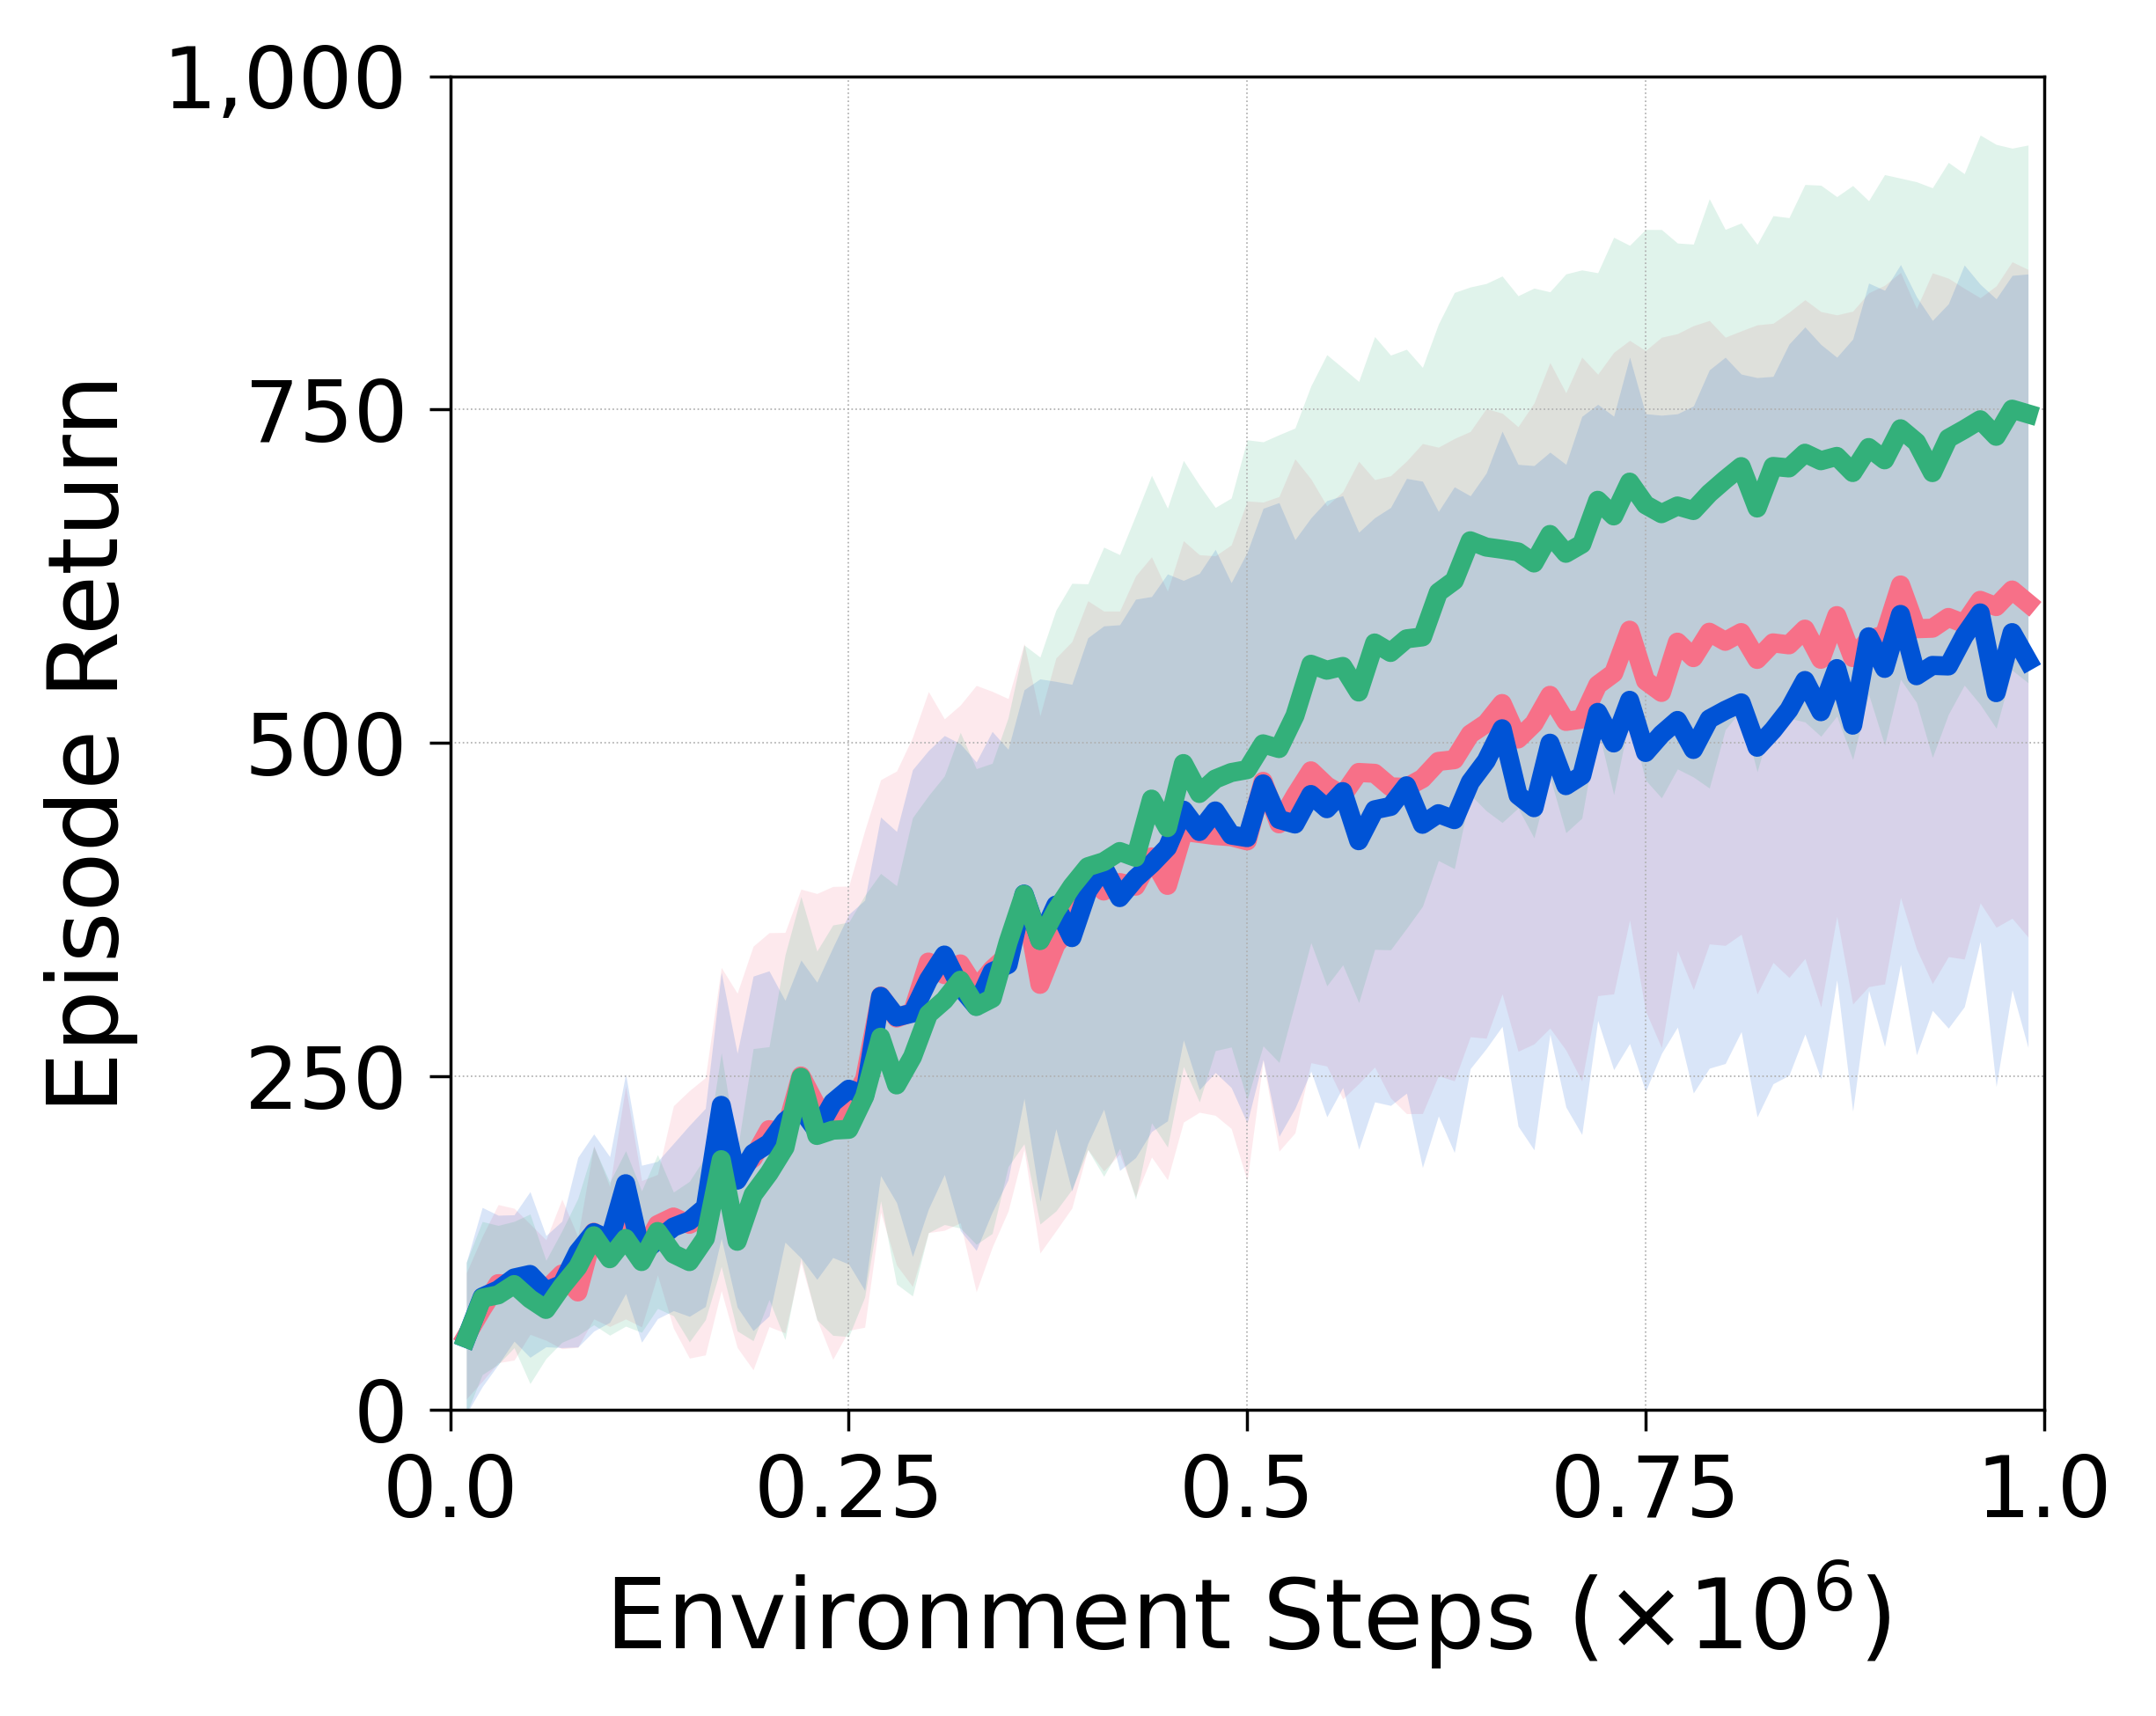

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000

teacher_flag_list = [('sch=0', color_list[0], 'Uniform schedule'), 
                     ('sch=1', color_list[2], 'Decay schedule'), 
                     ('sch=2', color_list[3], 'Increase schedule')]

for name in q_new_pebble_name_list:
    label = name
    score = q_new_pebble_avg[name]
    std = q_new_pebble_std[name]
    steps = q_new_pebble_step[name].reshape(-1)

    for (teacher_flag, ours_color, sample_name) in teacher_flag_list:        
        if teacher_flag in name:
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, sample_name)

ax.set_ylabel('Episode Return', fontsize=16)
ax.set_yticks([0, 250, 500, 750, 1000])
# ax.set_yticks([-250, 250, 750, 1250, 1750, 2250, 2750], minor=True)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_ylim(0, 1000)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=16)
ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=14)

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True
plt.tight_layout()
plt.savefig('./figure/fig3_quadruped.pdf')

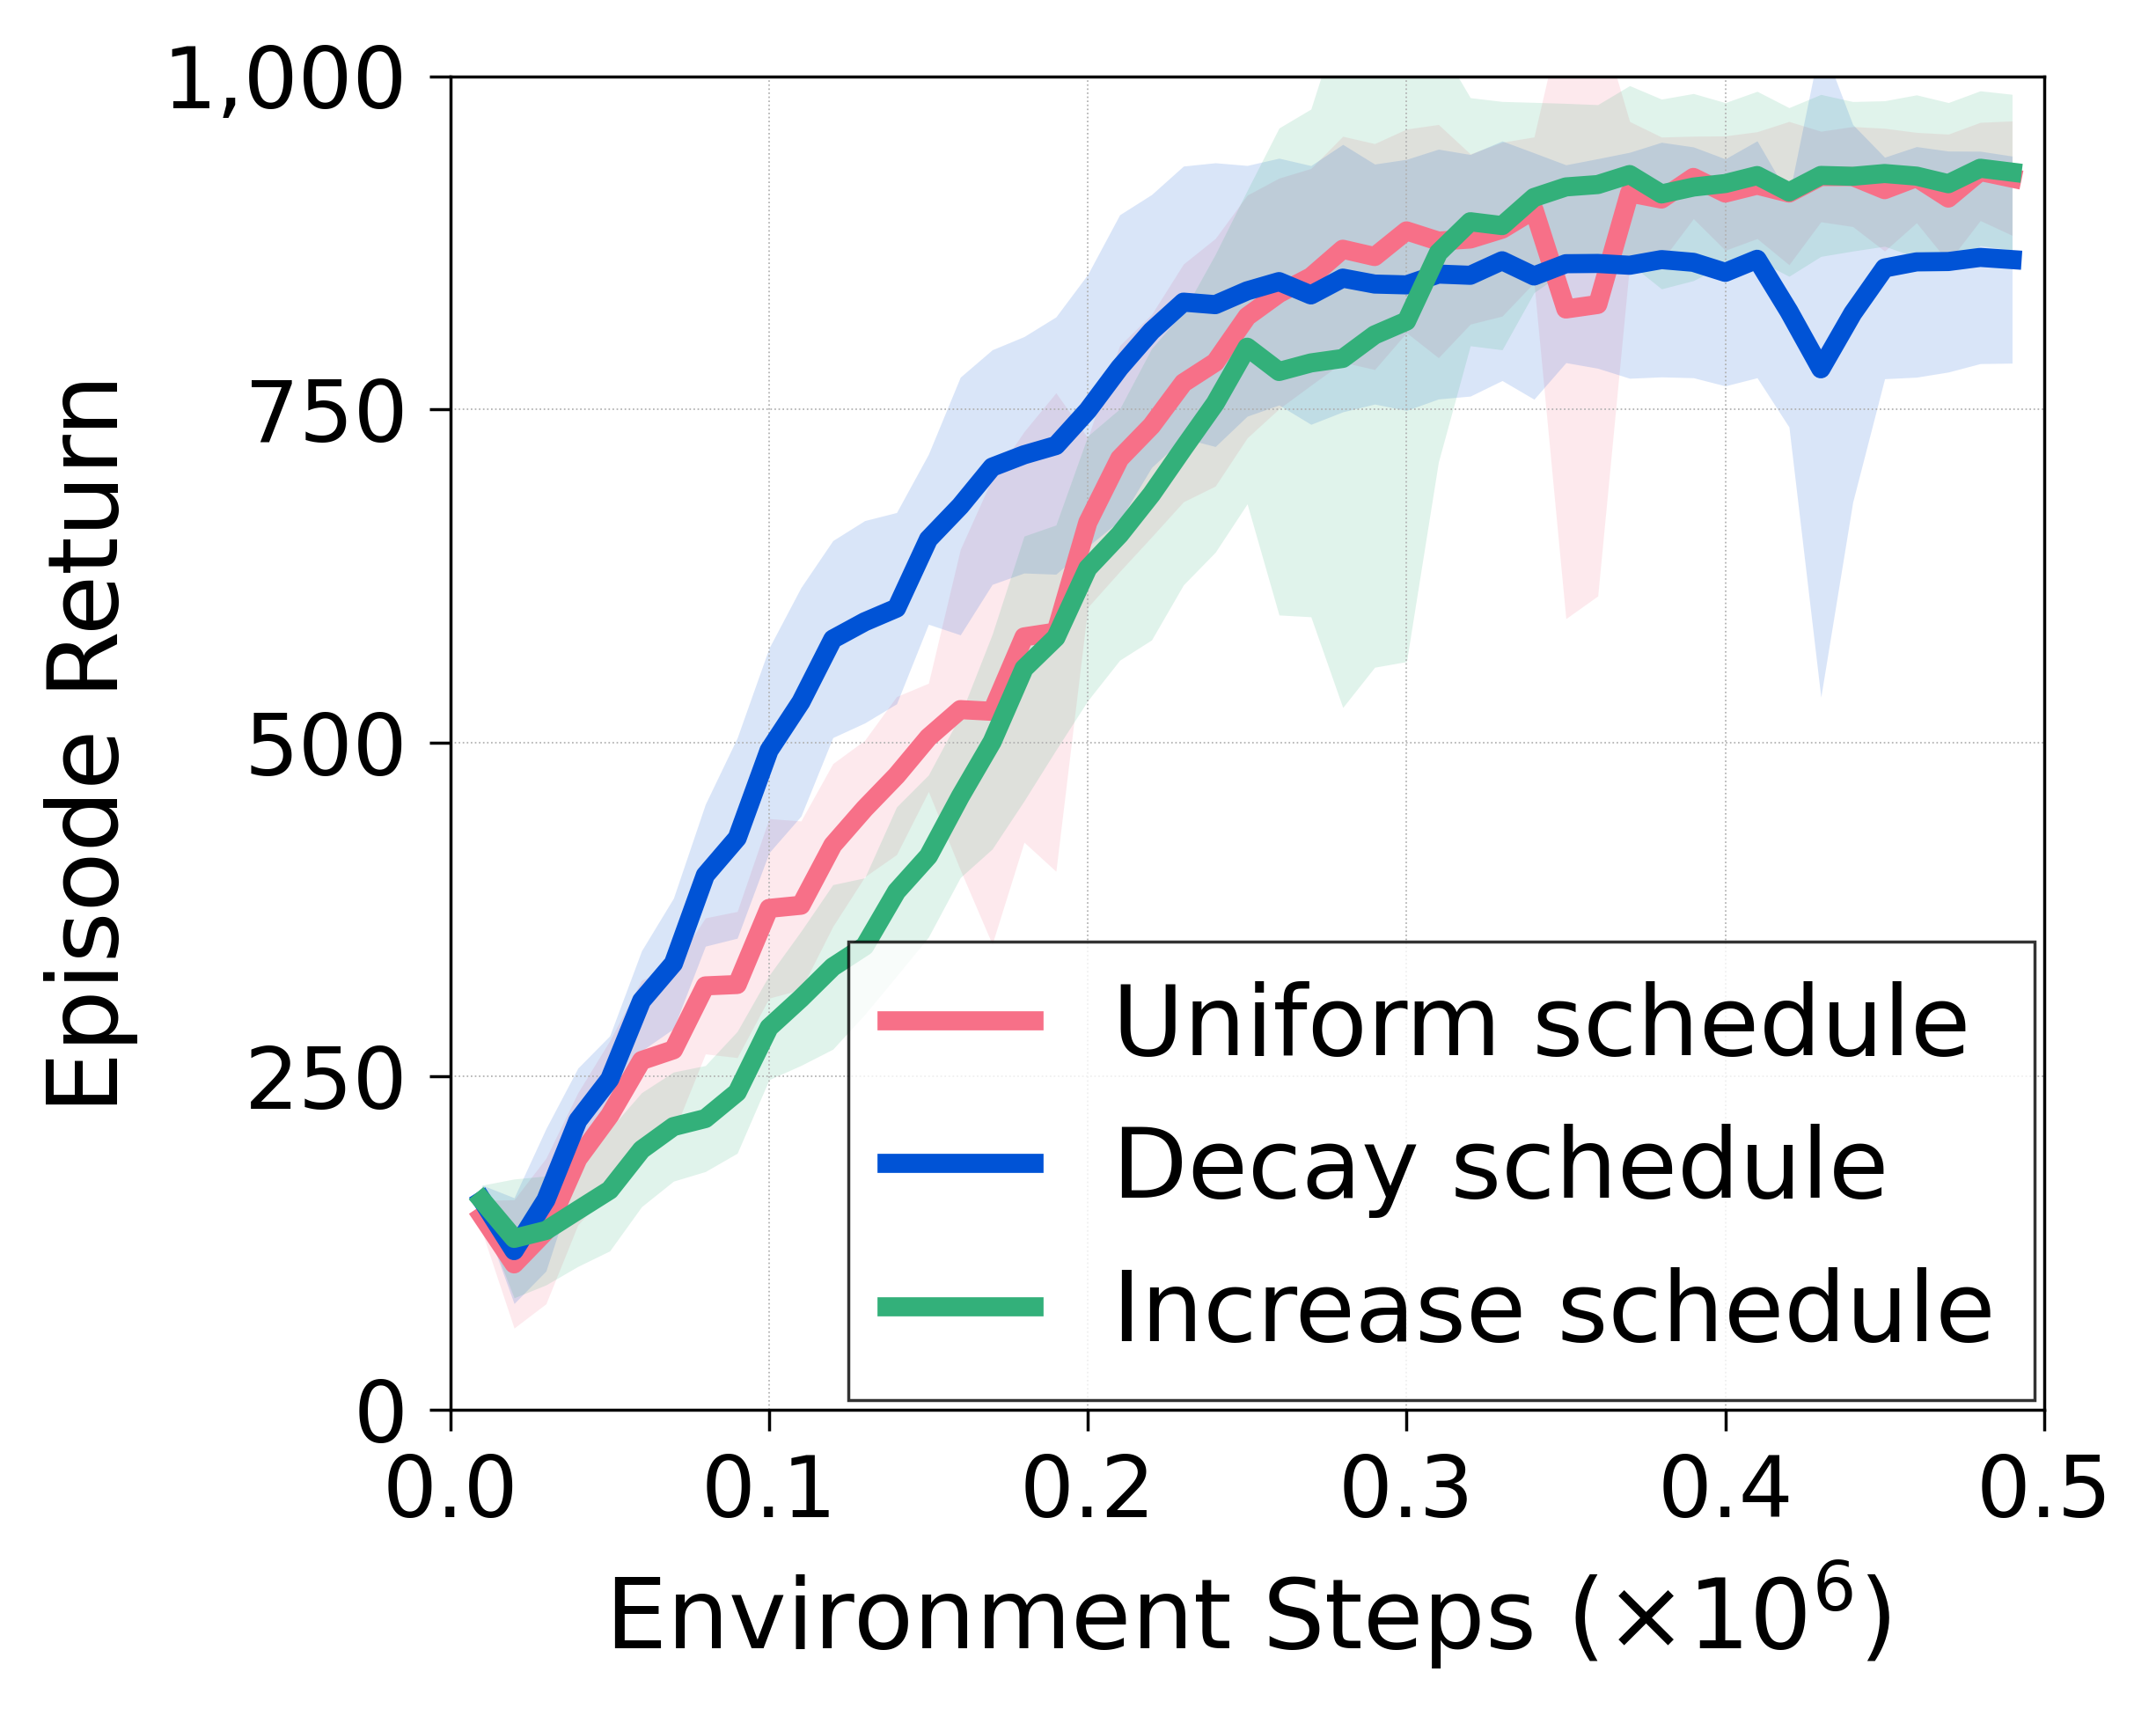

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000
for name in w_new_pebble_name_list:
    label = name
    score = w_new_pebble_avg[name]
    std = w_new_pebble_std[name]
    steps = w_new_pebble_step[name].reshape(-1)

    for (teacher_flag, ours_color, sample_name) in teacher_flag_list:        
        if teacher_flag in name:
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, sample_name)

ax.set_ylabel('Episode Return', fontsize=16)
ax.set_yticks([0, 250, 500, 750, 1000])

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_ylim(0, 1000)
ax.set_xlim(0, 0.5)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=16)
ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=14)


# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True

leg = ax.legend(fancybox=False, fontsize=16,
                edgecolor='black', borderaxespad=0.1, 
                handlelength=1.5, loc='lower right')
leg.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.savefig('./figure/fig3_walker.pdf')

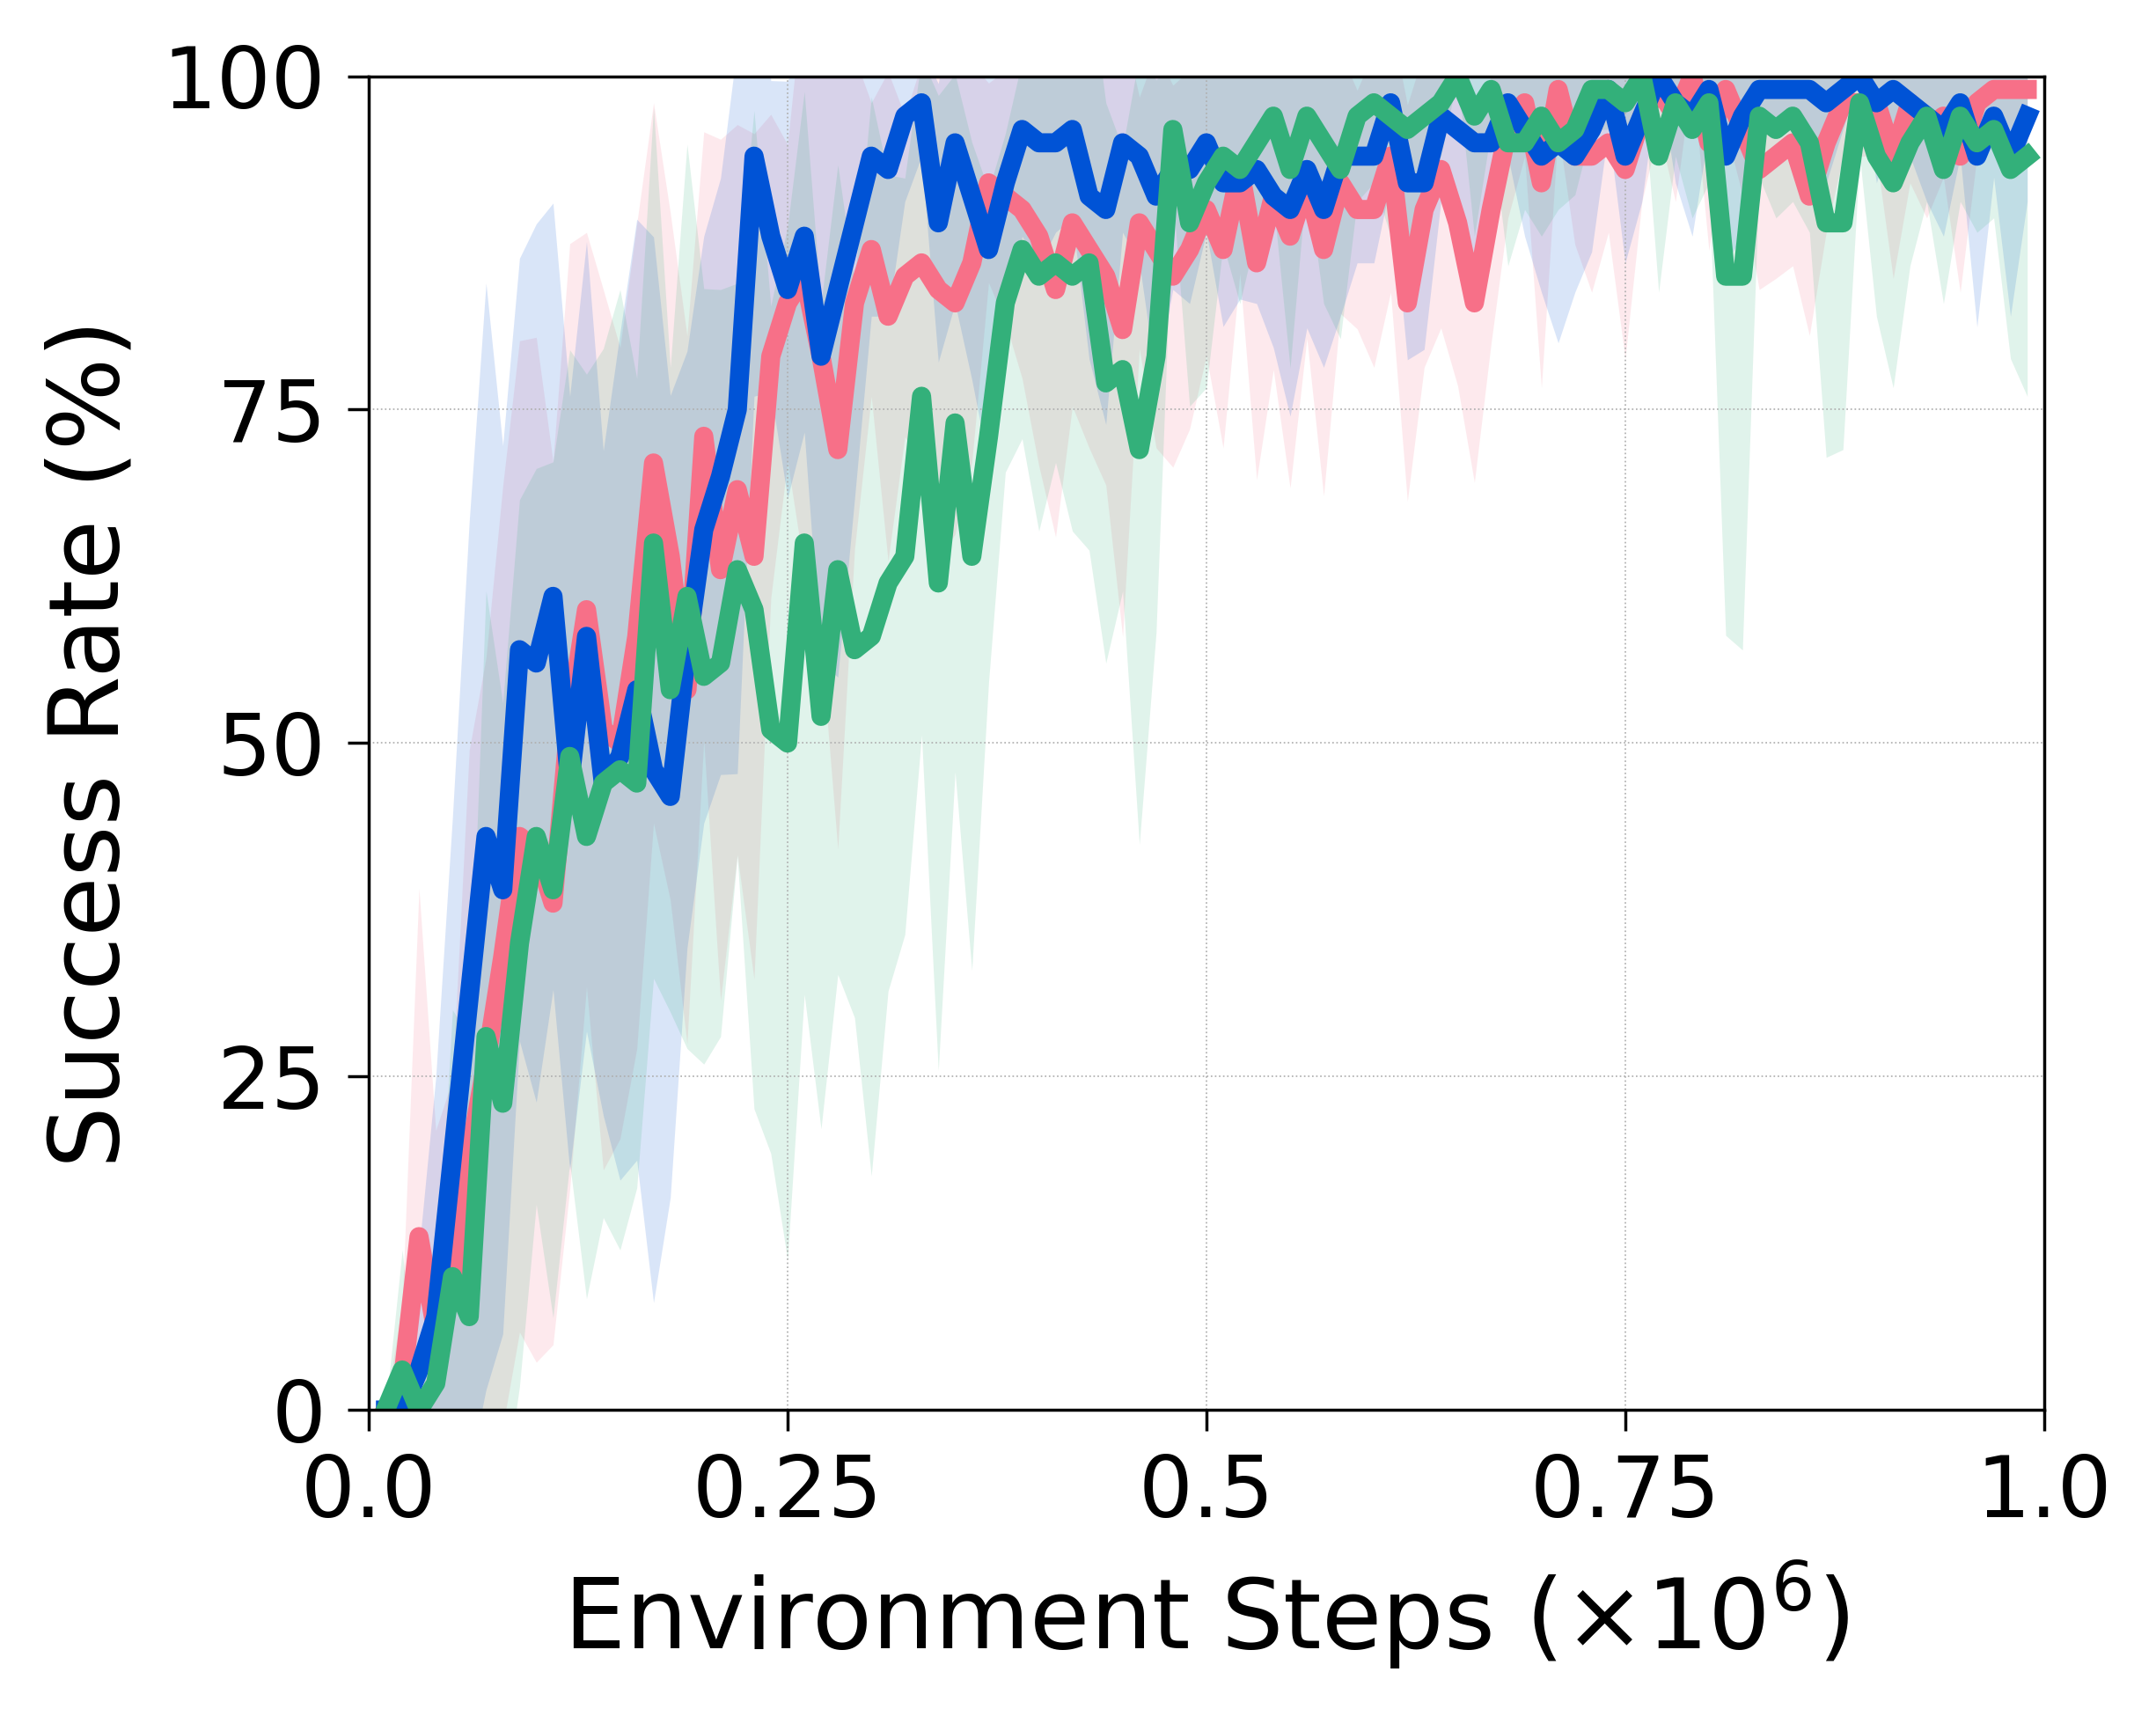

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000
for name in b_new_pebble_name_list:
    label = name
    score = b_new_pebble_s_avg[name]
    std = b_new_pebble_s_std[name]
    steps = b_new_pebble_s_step[name].reshape(-1)

    for (teacher_flag, ours_color, sample_name) in teacher_flag_list:        
        if teacher_flag in name:
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, sample_name)

ax.set_ylabel('Success Rate (%)', fontsize=16)
ax.set_yticks([0, 25, 50, 75, 100])
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_ylim(0, 100)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    
ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=16)
ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=14)

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True
plt.tight_layout()
plt.savefig('./figure/fig3_button.pdf')

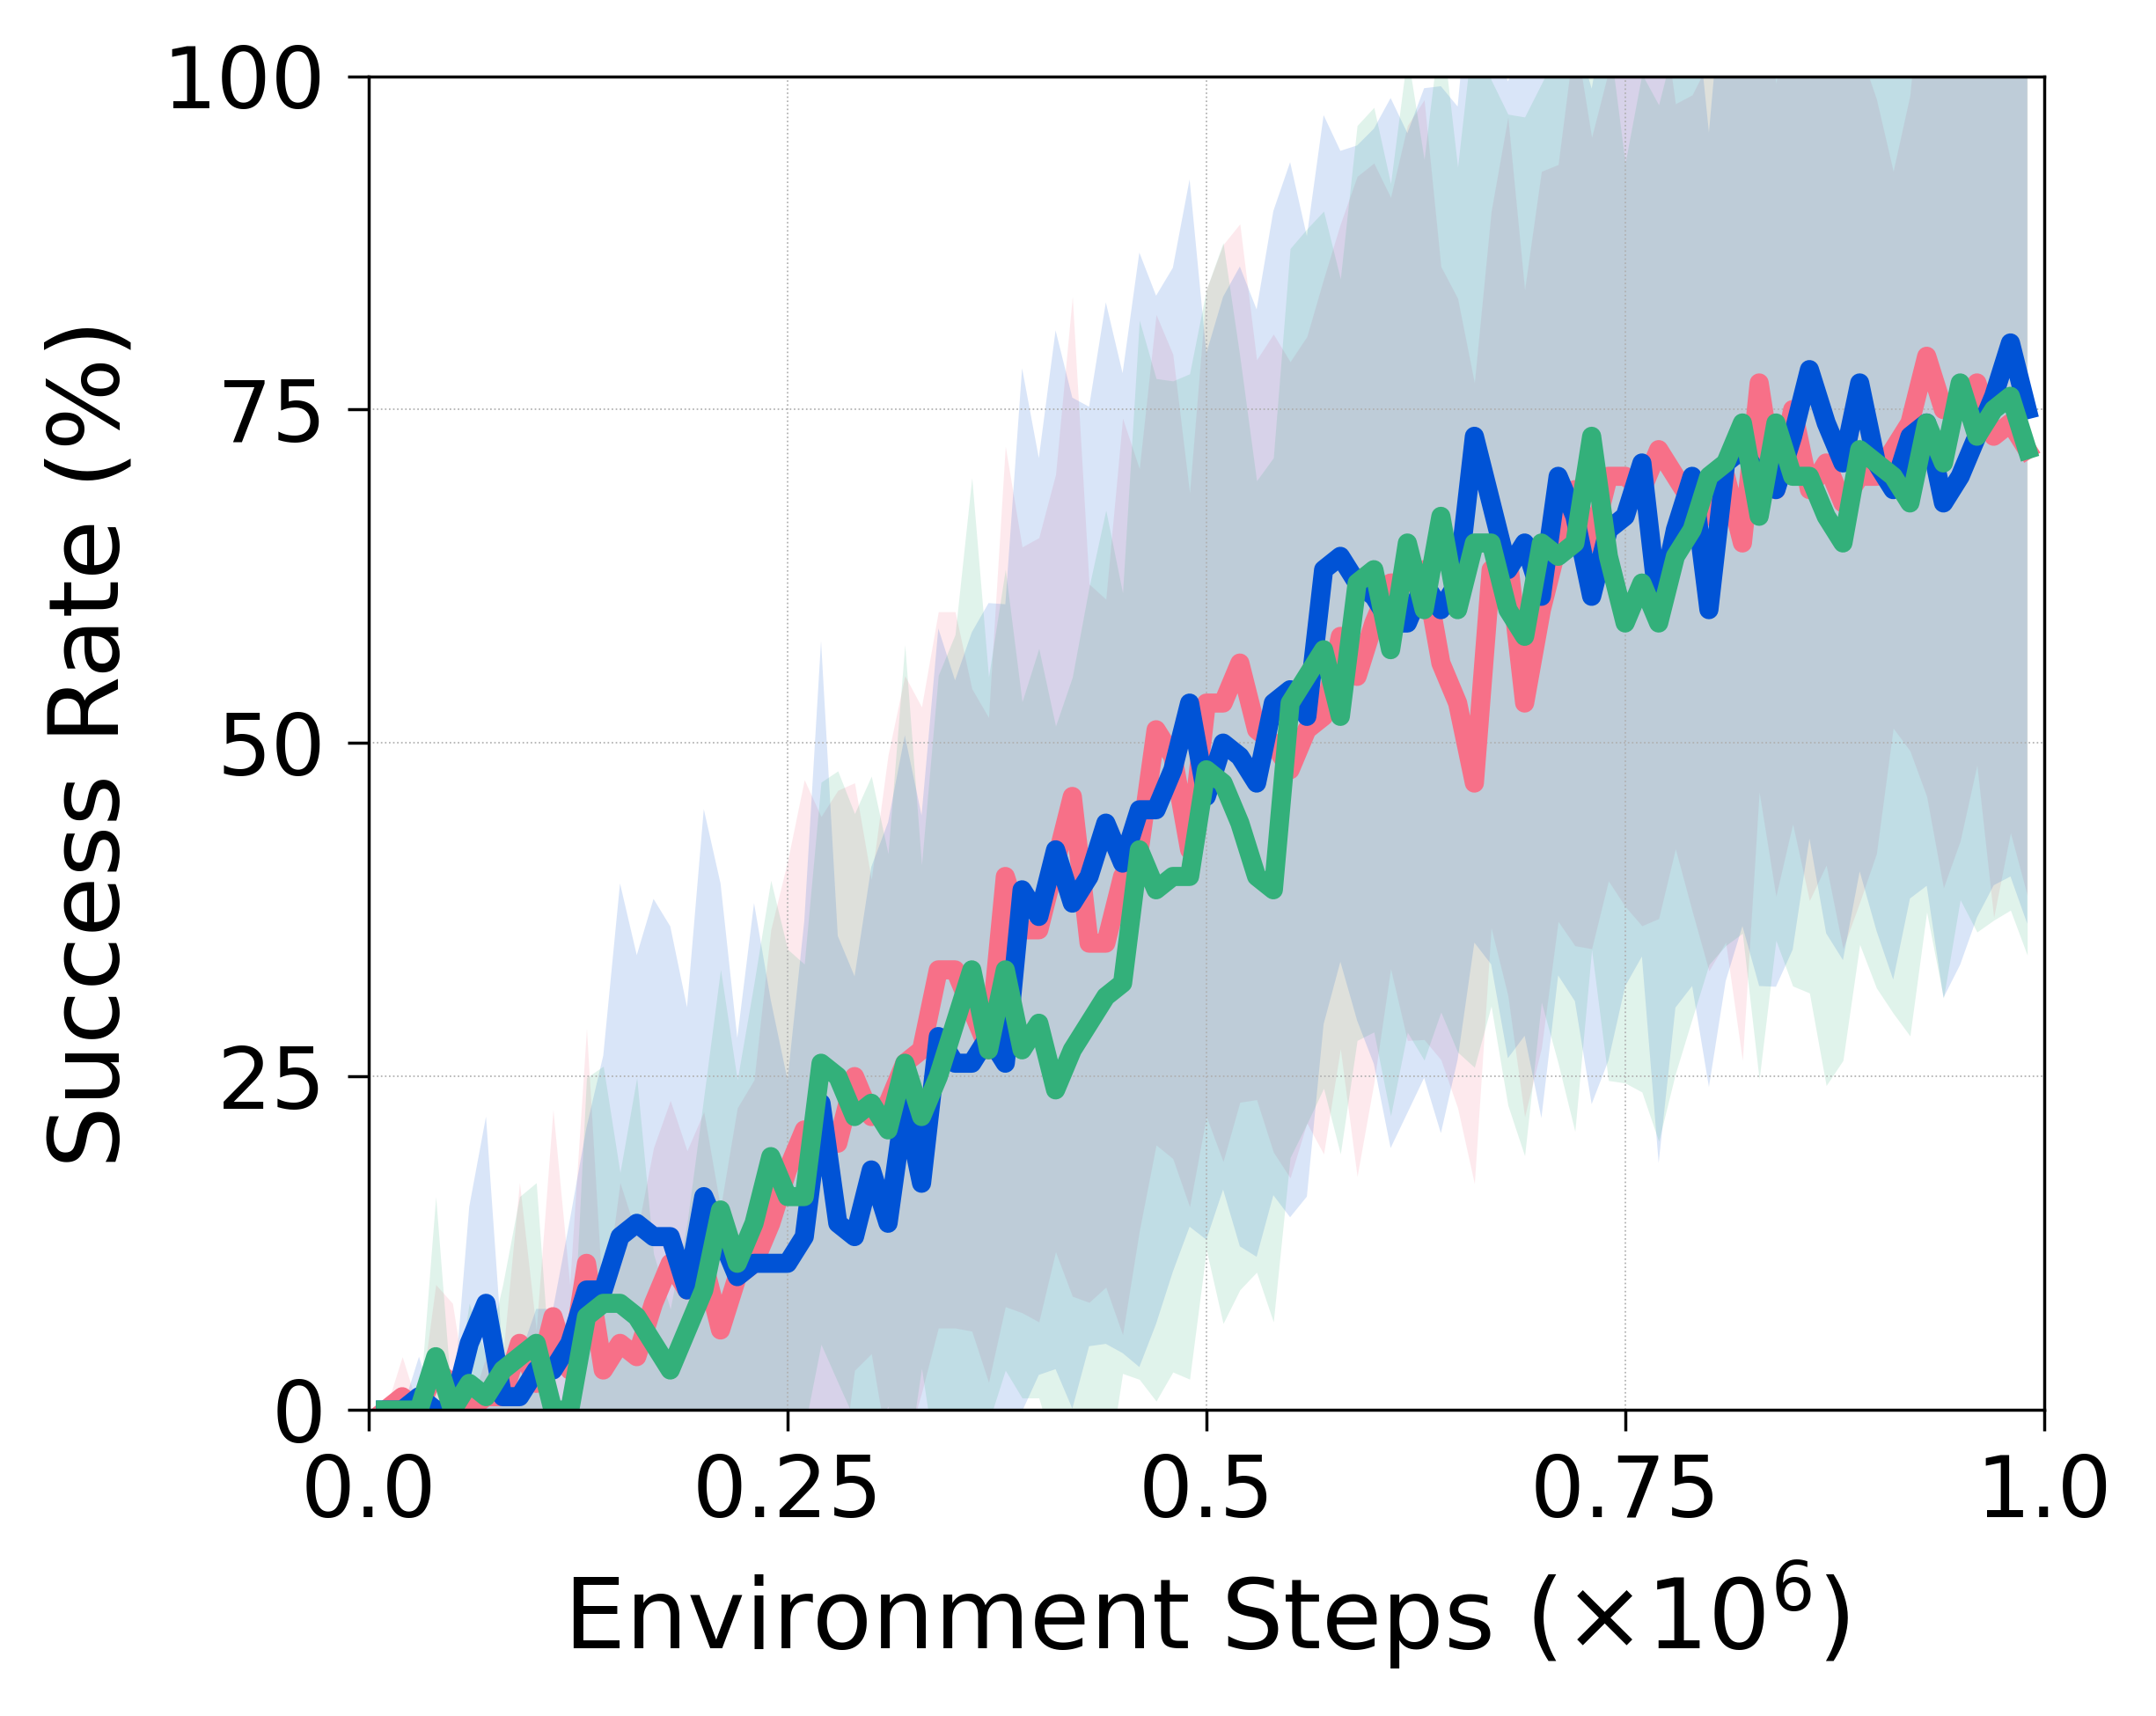

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=500)
base = 1000000
for name in s_new_pebble_name_list:
    label = name
    score = s_new_pebble_s_avg[name]
    std = s_new_pebble_s_std[name]
    steps = s_new_pebble_s_step[name].reshape(-1)

    for (teacher_flag, ours_color, sample_name) in teacher_flag_list:        
        if teacher_flag in name:
            ax = draw_figures(steps/base, score, std, ax, 
                              ours_color, sample_name)

ax.set_ylabel('Success Rate (%)', fontsize=16)
ax.set_yticks([0, 25, 50, 75, 100])
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_ylim(0, 100)
ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    
ax.set_xlabel('Environment Steps ($\\times 10^6%$)', fontsize=16)
ax.grid(alpha=1.0, linestyle=':', linewidth=0.25)
ax.tick_params(axis='both', which='major', labelsize=14)

# NOTE: use xtick with 10^4 or xlabel with 10^4
def set_xtick(x, p):
    return '{}'.format(x)

ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(set_xtick)
)
ax.xaxis.major.formatter._useMathText = True
plt.tight_layout()
plt.savefig('./figure/fig3_sweep.pdf')